In [1]:
# Importations & définition des variables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
import plotly.graph_objects as go
import matplotlib

# Chargement des données
fichier = "../Donnees_IA_2025.xlsx"
data = pd.read_excel(fichier)

data.columns = data.columns.str.strip()  # Nettoyage des noms de colonnes

data.head()

,Ordre,Code,Classe,Nom,Nom détaillé,Pays,Année récolte,Date mesure,MS % brut,PB % brut,...,ED porc croissance (kcal) kcal/kg brut,EM porc croissance (kcal) kcal/kg brut,EN porc croissance (kcal) kcal/kg brut,EMAn coq (kcal) kcal/kg brut,EMAn poulet (kcal) kcal/kg brut,UFL 2018 par kg brut,UFV 2018 par kg brut,PDIA 2018 g/kg brut,PDI 2018 g/kg brut,BalProRu 2018 g/kg brut
0,1,657397,Céréales,Avoine,Avoine,Canada,1976-01-01,1976-01-01,87.000000,9.5,...,2460,2380,1850,2610,2480,0.81,0.76,17,62,-10.0
1,2,657400,Céréales,Avoine,Avoine,Canada,1976-01-01,1976-01-01,87.000000,11.9,...,2580,2480,1880,2590,2460,0.88,0.85,22,69,5.0
2,3,657402,Céréales,Avoine,Avoine,Canada,1976-01-01,1976-01-01,87.400002,12.2,...,2760,2660,2030,2690,2560,0.95,0.92,22,70,6.0
3,4,657404,Céréales,Avoine,Avoine,Canada,1976-01-01,1976-01-01,88.800003,10.8,...,2150,2060,1500,2080,1950,0.77,0.72,20,65,-0.5
4,5,657405,Céréales,Avoine,Avoine,Canada,1976-01-01,1976-01-01,88.300003,11.6,...,2690,2590,2000,2750,2620,0.92,0.89,21,68,3.0


In [2]:
# Définition des variables quantitatives, cibles et qualitatives
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut", "EM porc croissance (kcal) kcal/kg brut",
    "EN porc croissance (kcal) kcal/kg brut", "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut", "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

vars_qual = ["Classe", "Nom"]

# Conversion des variables de composition et énergétiques en numérique
for col in vars_expl + vars_cibles:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors="coerce")

# Dictionnaire de noms réels -> noms simplifiés pour affichage
noms_simplifies = {
    "MS % brut": "MS",
    "PB % brut": "PB",
    "CB % brut": "CB",
    "MGR % brut": "MGR",
    "MM % brut": "MM",
    "NDF % brut": "NDF",
    "ADF % brut": "ADF",
    "Lignine % brut": "Lignine",
    "Amidon % brut": "Amidon",
    "Sucres % brut": "Sucres",
    "EB (kcal) kcal/kg brut": "EB",
    "ED porc croissance (kcal) kcal/kg brut": "ED porc",
    "EM porc croissance (kcal) kcal/kg brut": "EM porc",
    "EN porc croissance (kcal) kcal/kg brut": "EN porc",
    "EMAn coq (kcal) kcal/kg brut": "EMAn coq",
    "EMAn poulet (kcal) kcal/kg brut": "EMAn poulet",
    "UFL 2018 par kg brut": "UFL",
    "UFV 2018 par kg brut": "UFV",
    "PDIA 2018 g/kg brut": "PDIA",
    "PDI 2018 g/kg brut": "PDI",
    "BalProRu 2018 g/kg brut": "BalProRu"
}

# Aperçu des données
print(f"Nombre de variables explicatives : {len(vars_expl)}")
print(f"Nombre d'observations total : {data.shape[0]}")
print(f"Nombre de valeurs manquantes : {data.isnull().sum().sum()}")

Nombre de variables explicatives : 10
Nombre d'observations total : 3998
Nombre de valeurs manquantes : 0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# ============================================================================
# FONCTIONS
# ============================================================================

def prepare_data_random_split(data, features, target_cols, test_size=0.2, random_state=42):
    """
    Prépare les données avec un split aléatoire train/test.
    
    Args:
        data: DataFrame avec les données
        features: Liste des colonnes features
        target_cols: Liste des colonnes cibles
        test_size: Proportion du test set
        random_state: Graine aléatoire
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    X = data[features].copy()
    y = data[target_cols].copy()
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def prepare_data_hide_one_per_class(data, features, target_cols, class_col, random_state=42):
    """
    Prépare les données en cachant 1 produit par classe à l'entraînement.
    
    Args:
        data: DataFrame avec les données
        features: Liste des colonnes features
        target_cols: Liste des colonnes cibles
        class_col: Nom de la colonne classe
        random_state: Graine aléatoire
    
    Returns:
        X_train, X_test, y_train, y_test, classe_test, nom_test
    """
    # Sélectionner un produit par classe pour le test
    indices_test = data.groupby(class_col).apply(
        lambda x: x.sample(1, random_state=random_state)
    ).index.get_level_values(1)
    indices_train = data.index.difference(indices_test)
    
    X_train = data.loc[indices_train, features].copy()
    y_train = data.loc[indices_train, target_cols].copy()
    
    X_test = data.loc[indices_test, features].copy()
    y_test = data.loc[indices_test, target_cols].copy()
    
    classe_test = data.loc[indices_test, class_col].values
    nom_test = data.loc[indices_test, "Nom"].values
    
    return X_train, X_test, y_train, y_test, classe_test, nom_test


def add_encoded_feature(X_train, X_test, data, feature_name, indices_train, indices_test):
    """
    Ajoute une feature encodée (ex: Classe) à X_train et X_test.
    
    Args:
        X_train: DataFrame train
        X_test: DataFrame test
        data: DataFrame original
        feature_name: Nom de la feature à encoder
        indices_train: Indices d'entraînement
        indices_test: Indices de test
    
    Returns:
        X_train, X_test (modifiés avec la feature encodée)
    """
    le = LabelEncoder()
    feature_train = data.loc[indices_train, feature_name].values
    feature_test = data.loc[indices_test, feature_name].values
    
    encoded_train = le.fit_transform(feature_train)
    encoded_test = le.transform(feature_test)
    
    X_train[f"{feature_name}_encoded"] = encoded_train
    X_test[f"{feature_name}_encoded"] = encoded_test
    
    return X_train, X_test


def train_xgboost_models(X_train, X_test, y_train, y_test, target_cols, 
                          noms_simplifies, random_state=42):
    """
    Entraîne des modèles XGBoost pour chaque variable cible.
    
    Args:
        X_train, X_test: Features train/test
        y_train, y_test: Targets train/test
        target_cols: Liste des colonnes cibles
        noms_simplifies: Dict pour simplifier les noms
        random_state: Graine aléatoire
    
    Returns:
        DataFrame avec les métriques (MAE, RMSE, R2)
    """
    resultats = []
    
    for target in target_cols:
        model = xgb.XGBRegressor(random_state=random_state)
        model.fit(X_train, y_train[target])
        
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test[target], y_pred)
        rmse = np.sqrt(mean_squared_error(y_test[target], y_pred))
        r2 = r2_score(y_test[target], y_pred)
        
        resultats.append({
            'Variable cible': noms_simplifies[target],
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'R2': round(r2, 4)
        })
    
    return pd.DataFrame(resultats)


def display_hidden_products(classe_test, nom_test):
    """
    Affiche les produits cachés à l'entraînement.
    
    Args:
        classe_test: Array des classes de test
        nom_test: Array des noms de test
    """
    test_products = pd.DataFrame({
        'Classe': classe_test,
        'Nom': nom_test
    })
    print("Produits de test (cachés à l'entraînement):")
    print(test_products.to_string(index=False))


### XGBoost Model | variables explicatives : All features

In [4]:
# Préparation des données avec split aléatoire
X_train_all, X_test_all, y_train_all, y_test_all = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

# Entraînement des modèles et calcul des métriques
resultats_all_df = train_xgboost_models(
    X_train_all, X_test_all, y_train_all, y_test_all, 
    vars_cibles, noms_simplifies, random_state=42
)

print(resultats_all_df.to_string(index=False))

Variable cible   MAE  RMSE     R2
            EB 23.72 40.00 0.9930
       ED porc 32.95 56.07 0.9917
       EM porc 33.32 60.19 0.9896
       EN porc 23.80 38.43 0.9950
      EMAn coq 36.29 60.28 0.9939
   EMAn poulet 38.23 64.81 0.9925
           UFL  0.01  0.02 0.9847
           UFV  0.01  0.03 0.9859
          PDIA  1.87  5.20 0.9961
           PDI  2.06  5.98 0.9945
      BalProRu  2.57  5.12 0.9970


### XGBoost Model | variables explicatives : MS % brut & PB % brut

In [5]:
# Sélectionner uniquement les variables explicatives
vars_expl_selected = ["MS % brut", "PB % brut"]

# Préparation des données
X_train, X_test, y_train, y_test = prepare_data_random_split(
    data, vars_expl_selected, vars_cibles, test_size=0.2, random_state=42
)

# Entraînement des modèles
resultats_MS_PB_df = train_xgboost_models(
    X_train, X_test, y_train, y_test, 
    vars_cibles, noms_simplifies, random_state=42
)

print(resultats_MS_PB_df.to_string(index=False))

Variable cible    MAE   RMSE     R2
            EB 180.97 366.77 0.4134
       ED porc 345.08 524.85 0.2722
       EM porc 340.79 518.93 0.2263
       EN porc 325.85 523.88 0.0682
      EMAn coq 425.34 688.55 0.2055
   EMAn poulet 408.15 652.66 0.2436
           UFL   0.11   0.17 0.2411
           UFV   0.13   0.19 0.2214
          PDIA  14.07  27.16 0.8935
           PDI  13.17  25.78 0.8983
      BalProRu  15.26  27.77 0.9111


### XGBoost Model | variables explicatives : MS % brut & PB % brut & Classe encoded

In [6]:
# Variables explicatives sélectionnées
vars_expl_with_classe = ["MS % brut", "PB % brut"]

# Préparation des données avec split aléatoire
X_train_sel, X_test_sel, y_train_sel, y_test_sel = prepare_data_random_split(
    data, vars_expl_with_classe, vars_cibles, test_size=0.2, random_state=42
)

# Indices pour la feature encodée
indices_train = X_train_sel.index
indices_test = X_test_sel.index

# Ajouter la variable Classe encodée
X_train_sel, X_test_sel = add_encoded_feature(
    X_train_sel, X_test_sel, data, "Classe", indices_train, indices_test
)

# Entraînement des modèles
resultats_MS_PB_Classe_df = train_xgboost_models(
    X_train_sel, X_test_sel, y_train_sel, y_test_sel, 
    vars_cibles, noms_simplifies, random_state=42
)

print(resultats_MS_PB_Classe_df.to_string(index=False))

Variable cible    MAE   RMSE     R2
            EB  80.03 138.15 0.9168
       ED porc 161.60 247.71 0.8379
       EM porc 157.74 245.10 0.8274
       EN porc 140.82 217.58 0.8393
      EMAn coq 164.43 256.08 0.8901
   EMAn poulet 175.74 267.87 0.8726
           UFL   0.05   0.08 0.8463
           UFV   0.06   0.09 0.8338
          PDIA   5.05  11.89 0.9796
           PDI   5.24  12.32 0.9768
      BalProRu   6.07  12.43 0.9822


### XGBoost Model | variables explicatives : MS % brut & PB % brut & Classe encoded
### Un Nom par Classe caché à l'entrainement et utilisé en test uniquement pour voir l'impact sur la performance du modèle d'un produit inconnu assimilé à une classe existante.

In [7]:
# Variables explicatives sélectionnées
vars_expl_hide = ["MS % brut", "PB % brut"]

# Préparation des données en cachant 1 produit par classe
X_train, X_test, y_train, y_test, classe_test, nom_test = prepare_data_hide_one_per_class(
    data, vars_expl_hide, vars_cibles, "Classe", random_state=42
)

# Obtenir les indices pour l'ajout de la feature encodée
indices_train = X_train.index
indices_test = X_test.index

# Ajouter la variable Classe encodée
X_train, X_test = add_encoded_feature(
    X_train, X_test, data, "Classe", indices_train, indices_test
)

# Entraînement des modèles
resultats_hide_df = train_xgboost_models(
    X_train, X_test, y_train, y_test, 
    vars_cibles, noms_simplifies, random_state=42
)

print("Résultats du modèle avec MS, PB et Classe:")
print(resultats_hide_df.to_string(index=False))
print()

# Afficher les produits cachés à l'entraînement
display_hidden_products(classe_test, nom_test)

/tmp/ipykernel_14974/2146885868.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices_test = data.groupby(class_col).apply(


Résultats du modèle avec MS, PB et Classe:
Variable cible    MAE   RMSE     R2
            EB  88.53 118.76 0.9141
       ED porc 105.84 135.09 0.9634
       EM porc  99.15 128.22 0.9600
       EN porc 110.50 137.46 0.9171
      EMAn coq 178.60 234.30 0.9019
   EMAn poulet 158.16 211.74 0.9199
           UFL   0.05   0.06 0.9197
           UFV   0.05   0.06 0.9483
          PDIA   9.31  26.92 0.9513
           PDI   7.91  20.71 0.9698
      BalProRu   9.05  22.78 0.9547

Produits de test (cachés à l'entraînement):
                                Classe                                          Nom
         Amidon, racines et tubercules                      Manioc, amidon 70-74 % 
        Autres coproduits des céréales Radicelles d'orge de brasserie déshydratées 
              Autres produits végétaux              Concentré protéique de luzerne 
       Coproduits d'animaux terrestres                   Farine de viande (toutes) 
       Coproduits de fruits et légumes                 Pulpe

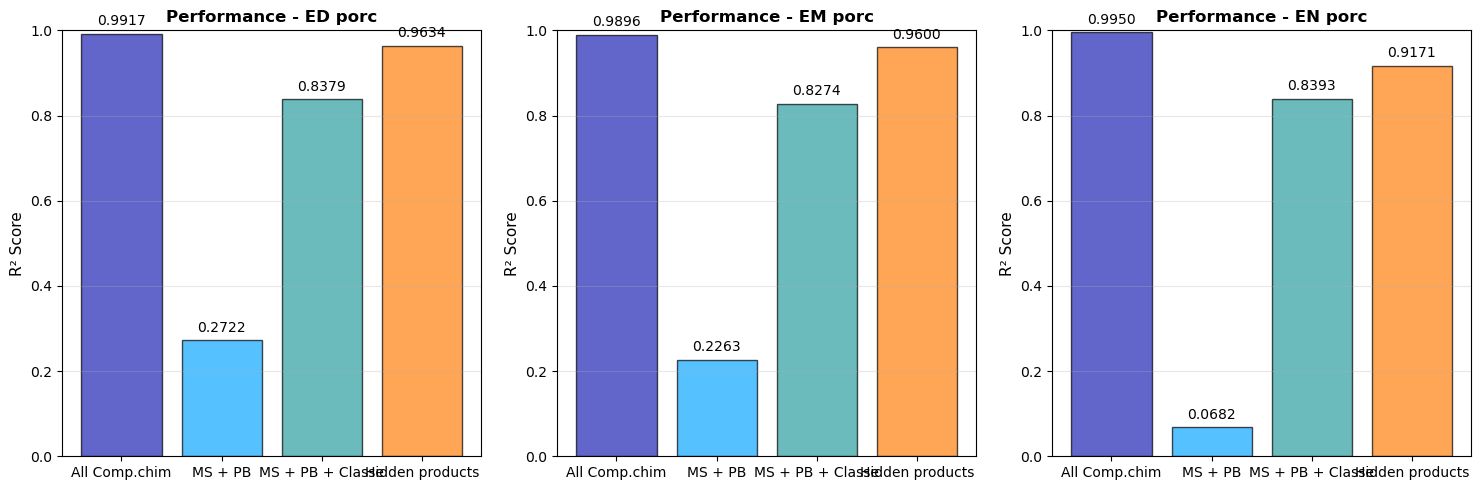

In [8]:
# Graphique comparatif des performances pour ED porc, EM porc et EN porc
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

targets = ["ED porc croissance (kcal) kcal/kg brut", "EM porc croissance (kcal) kcal/kg brut", "EN porc croissance (kcal) kcal/kg brut"]
target_names = ["ED porc", "EM porc", "EN porc"]

for idx, (target, target_name) in enumerate(zip(targets, target_names)):
    r2_all = resultats_all_df[resultats_all_df['Variable cible'] == target_name]['R2'].values[0]
    r2_MS_PB = resultats_MS_PB_df[resultats_MS_PB_df['Variable cible'] == target_name]['R2'].values[0]
    r2_MS_PB_Classe = resultats_MS_PB_Classe_df[resultats_MS_PB_Classe_df['Variable cible'] == target_name]['R2'].values[0]
    r2_hide = resultats_hide_df[resultats_hide_df['Variable cible'] == target_name]['R2'].values[0]

    models = ['All Comp.chim', 'MS + PB', 'MS + PB + Classe', 'Hidden products']
    r2_scores = [r2_all, r2_MS_PB, r2_MS_PB_Classe, r2_hide]
    colors = ["#1f24b4", "#0ea7ff", "#2c9ea0", "#ff7f0e"]
    
    axes[idx].bar(models, r2_scores, color=colors, alpha=0.7, edgecolor='black')
    axes[idx].set_ylabel('R² Score', fontsize=11)
    axes[idx].set_title(f'Performance - {target_name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3)
    
    for i, (model, r2) in enumerate(zip(models, r2_scores)):
        axes[idx].text(i, r2 + 0.02, f'{r2:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()